In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

!curl -O https://lazyprogrammer.me/course_files/timeseries/us_macro_quarterly.xlsx

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 55 76805   55 42902    0     0   108k      0 --:--:-- --:--:-- --:--:--  108k
100 76805  100 76805    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k


In [3]:
df = pd.read_excel('us_macro_quarterly.xlsx')
df.head()

c:\aconda\envs\time_series_env\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


In [5]:
def parse_date(data):
  # quarter is in {01,02,03,04}
  year, quarter = data.split(':')
  month = (int(quarter) - 1) * 3 + 1
  s = f"{year}-{month}"
  return datetime.strptime(s, "%Y-%m")

In [6]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


In [7]:
df.set_index(df['Date'], inplace=True)
df.drop(['Date', 'Unnamed: 0'], axis=1, inplace=True)
df.index.freq = 'QS'
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


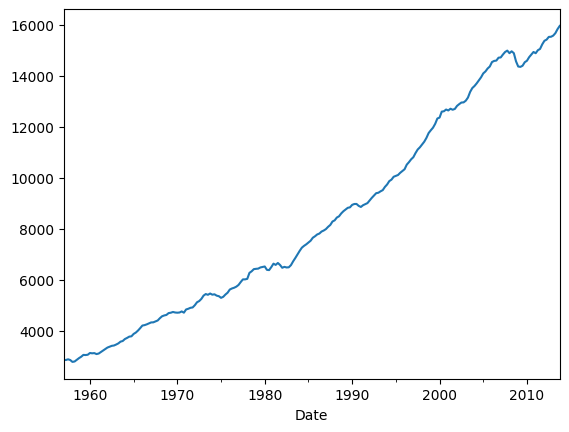

In [8]:
# GDP
df['GDPC96'].plot();

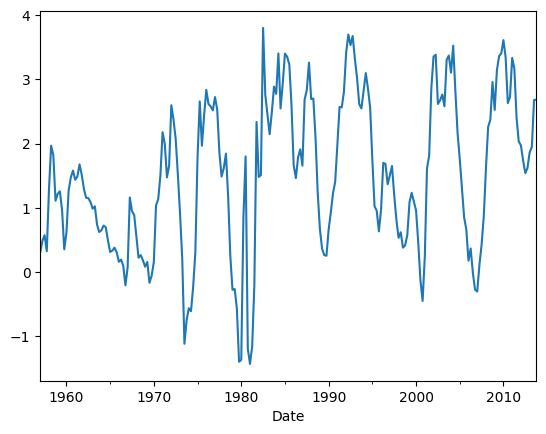

In [9]:
df['GDPGrowth'] = np.log(df['GDPC96']).diff()
df['TSpread'] = df['GS10'] - df['TB3MS']
df['TSpread'].plot();

In [10]:
cols = ['GDPGrowth', 'TSpread']

# 1 for exclusing the first nan term
df1 = df.iloc[1:][cols].copy()

In [11]:
Ntest = 12
train = df1.iloc[:-Ntest].copy()
test = df1.iloc[-Ntest:].copy()
train_idx = df1.index <= train.index[-1]
test_idx = ~train_idx

In [12]:
scalar = StandardScaler()
train[cols] = scalar.fit_transform(train)
test[cols] = scalar.fit_transform(test)
df1.iloc[train_idx, :] = train
df1.iloc[test_idx, :] = test

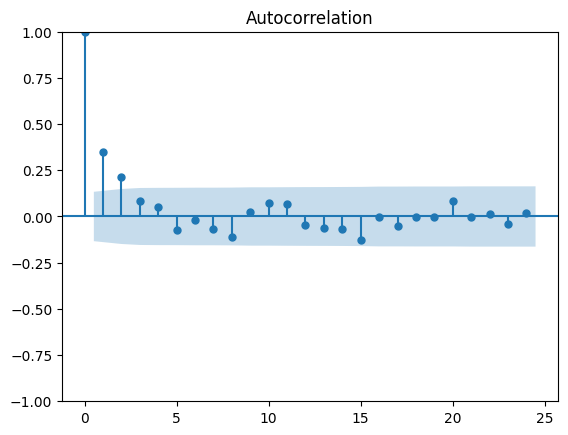

In [13]:
plot_acf(train['GDPGrowth']);

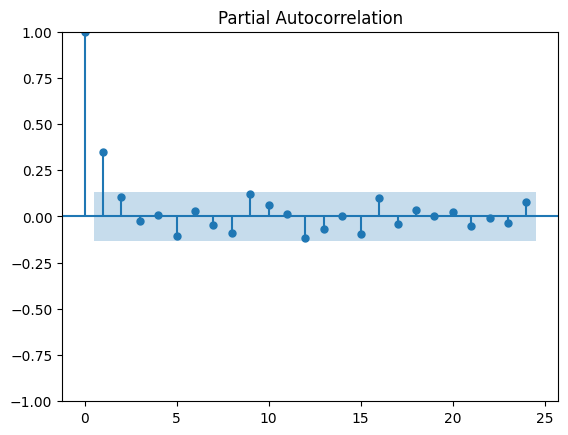

In [14]:
plot_pacf(train['GDPGrowth']);

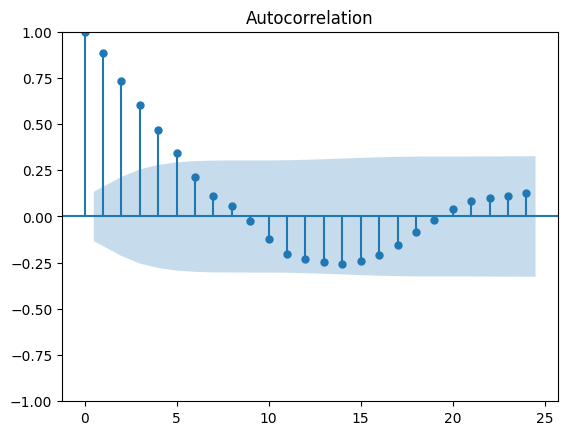

In [15]:
plot_acf(train['TSpread']);

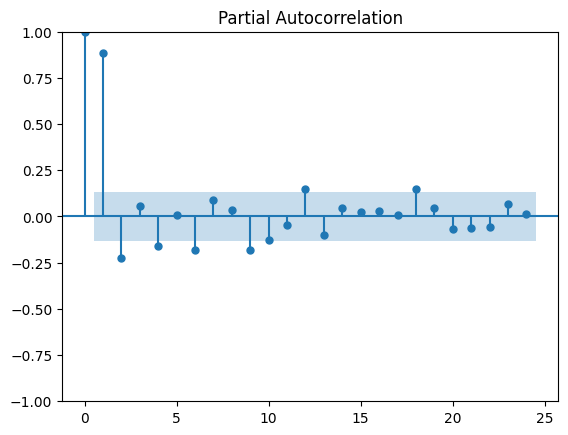

In [16]:
plot_pacf(train['TSpread']);

In [17]:
adfuller(train['GDPGrowth'])

(-7.4466396546255815,
 5.814896580913804e-11,
 1,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 512.854231063742)

In [18]:
adfuller(train['TSpread'])

(-4.001020795475582,
 0.001405175490749354,
 12,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 246.36949884218734)

In [19]:
# Based on PACF/ACF for the two series
p = 18
q = 1

In [20]:
t0 = datetime.now()
model = VARMAX(train, order=(p, q))
res = model.fit(maxiter=100)
print("Duration:", datetime.now() - t0)

c:\aconda\envs\time_series_env\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
c:\aconda\envs\time_series_env\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\aconda\envs\time_series_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:06:29.253134


In [21]:
fcast = res.get_forecast(Ntest)
confint = fcast.conf_int()

In [27]:
df1.loc[train_idx, 'Train Pred TSpread'] = res.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast.predicted_mean['TSpread']

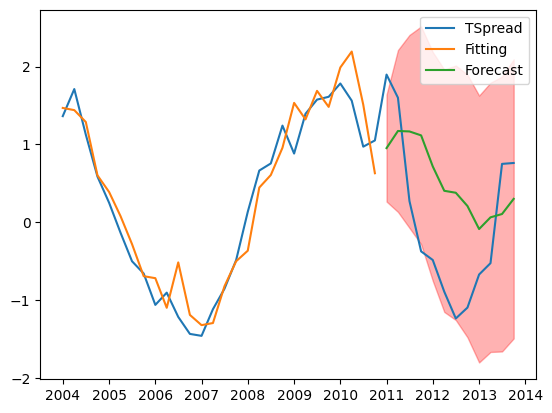

In [32]:
fig, ax = plt.subplots()
plot_cols = ['TSpread', 'Train Pred TSpread', 'Test Pred TSpread']
labels = ['TSpread', 'Fitting', 'Forecast']

for col, label in zip(plot_cols, labels):
    ax.plot(df1.iloc[-40:][col], label=label)
    
ax.fill_between(test.index, confint['upper TSpread'], confint['lower TSpread'],
                color='red', alpha=0.3)

ax.legend();

In [34]:
for col in cols:
    y_true = df1.loc[train_idx, col]
    y_pred = res.fittedvalues[col]
    print("Train R^2:", r2_score(y_true, y_pred))

    y_true = df1.loc[test_idx, col]
    y_pred = fcast.predicted_mean[col]
    print("Test R^2:", r2_score(y_true, y_pred))

Train R^2: 0.27639130813509594
Test R^2: 0.023885494365240123
Train R^2: 0.8736997818065428
Test R^2: -0.07042931846966138


### VAR

In [36]:
model = VAR(train)
lag_order_results = model.select_order(maxlags=20)
lag_order_results.selected_orders

{'aic': 10, 'bic': 1, 'hqic': 2, 'fpe': 10}

In [38]:
results = model.fit(maxlags=20, ic='aic')
lag_order = results.k_ar
lag_order

10

In [39]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior, Ntest)

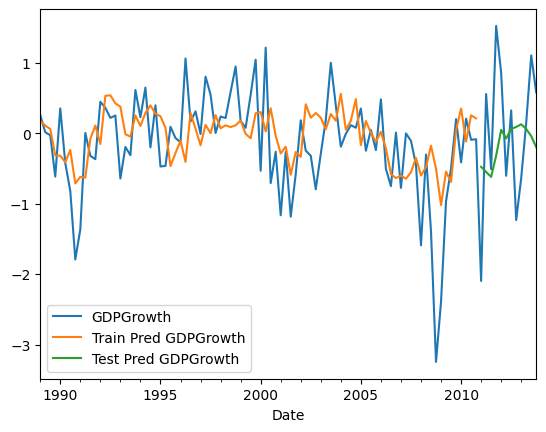

In [40]:
df1.loc[train_idx, 'Train Pred GDPGrowth'] = results.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test Pred GDPGrowth'] = fcast[:,0]
plot_cols = ['GDPGrowth', 'Train Pred GDPGrowth', 'Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot();

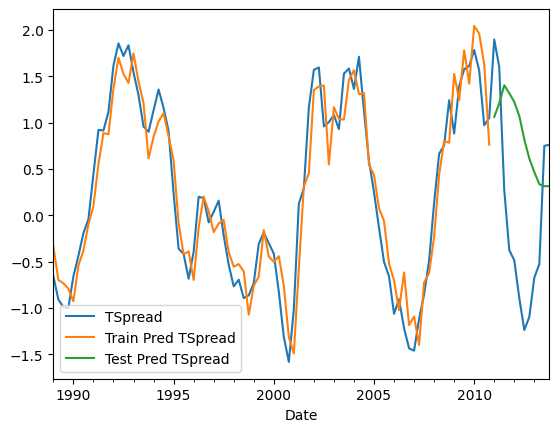

In [41]:
df1.loc[train_idx, 'Train Pred TSpread'] = results.fittedvalues['TSpread']
df1.loc[test_idx, 'Test Pred TSpread'] = fcast[:,1]
plot_cols = ['TSpread', 'Train Pred TSpread', 'Test Pred TSpread']
df1.iloc[-100:][plot_cols].plot();

In [42]:
y_pred = df1.loc[train_idx, 'Train Pred GDPGrowth']
y_true = df1.loc[train_idx, 'GDPGrowth']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("GDPGrowth Train R^2:", r2_score(y_true, y_pred))

y_pred = df1.loc[test_idx, 'Test Pred GDPGrowth']
y_true = df1.loc[test_idx, 'GDPGrowth']
print("GDPGrowth Test R^2:", r2_score(y_true, y_pred))

GDPGrowth Train R^2: 0.2569812409739455
GDPGrowth Test R^2: -0.043148231655072866


In [43]:
y_pred = df1.loc[train_idx, 'Train Pred TSpread']
y_true = df1.loc[train_idx, 'TSpread']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print("TSpread Train R^2:", r2_score(y_true, y_pred))

y_pred = df1.loc[test_idx, 'Test Pred TSpread']
y_true = df1.loc[test_idx, 'TSpread']
print("TSpread Test R^2:", r2_score(y_true, y_pred))

TSpread Train R^2: 0.8581031996649262
TSpread Test R^2: -0.7786977776252815


### Compare to ARIMA baseline

In [44]:
for col in cols:
    model = ARIMA(train[col], order=(p, 0, q))
    res = model.fit()
    fcast = res.get_forecast(Ntest)
    y_train = df1.loc[train_idx, col]
    y_test = df1.loc[test_idx, col]
    print(f"{col} Train R^2:", r2_score(y_train, res.fittedvalues))
    print(f"{col} Test R^2:", r2_score(y_test, fcast.predicted_mean))

GDPGrowth Train R^2: 0.20569396190676292
GDPGrowth Test R^2: -0.06706179765564135
TSpread Train R^2: 0.833248653171751
TSpread Test R^2: 0.41202370955663226
